# 🧠 Interprétation de modèle avec SHAP  
Dans ce notebook, nous allons charger les librairies essentielles et préparer l’environnement pour analyser les contributions de chaque feature aux prédictions du modèle.  
Les outils principaux seront :  
- **SHAP** pour l’explication locale et globale des prédictions  
- **Matplotlib / Seaborn** pour la visualisation  
- **Joblib** pour charger le modèle  
- **NumPy / Pandas** pour la manipulation des données  


In [38]:
# 📚 Importation des librairies principales
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## 📂 Chargement des données et du modèle  
Dans cette section, nous chargeons :  
- **x_train / X_test** : les datasets utilisés pour entraîner et tester le modèle  
- **model** : le meilleur modèle XGBoost sauvegardé  
- **seuil_best** : le seuil de décision optimisé pour la classification  
- **y_prob_test** : les probabilités prédites sur le jeu de test  
- **y_test_pred_base / y_test_pred_opt** : les prédictions brutes et avec seuil optimisé  

Ces éléments sont nécessaires pour analyser les explications SHAP sur les mêmes données que celles utilisées pour l’évaluation du modèle.


In [39]:
# 📂 Chargement des données et du modèle
x_train=joblib.load("x_train.joblib")
X_test=joblib.load("X_test.joblib")
model=joblib.load("xgb_model_best.joblib")
seuil_best=joblib.load("best_thresh.joblib")


# 📊 Chargement des prédictions
y_prob_test=joblib.load("y_prob_test.joblib")
y_test_pred_base=joblib.load("y_test_pred_base.joblib")
y_test_pred_opt=joblib.load("y_test_pred_opt.joblib")



# Préparation des données (train/test) et calcul des valeurs SHAP

In [91]:
# Création des noms de variables pour toutes les features
feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]


# Conversion des matrices X_train et X_test en DataFrames nommés
# → utile pour afficher les noms des features dans les graphiques SHAP
X_test_shape = pd.DataFrame(X_test, columns=feature_names) 
X_train_shape = pd.DataFrame(x_train, columns=feature_names) 

# Initialisation d’un TreeExplainer pour analyser les prédictions du modèle
explainer = shap.TreeExplainer(model)

# Calcul des valeurs SHAP sur l'ensemble d'entraînement
# → utile pour les analyses SHAP globales (feature importance globale)
shap_value_train = explainer(X_train_shape)

# Calcul des valeurs SHAP sur l'ensemble de test
# → SHAP local, permet d'expliquer chaque prédiction individuellement
shap_value = explainer(X_test_shape)





# Distribution des valeurs SHAP pour la classe 1 (COVID) – Zoom sur les faibles contributions

Cette cellule analyse la distribution globale des valeurs SHAP pour la classe 1 (COVID).
 
 1. On récupère toutes les valeurs SHAP du modèle sur l'ensemble d'entraînement pour la classe 1.
 2. On affiche un histogramme zoomé autour de 0 pour visualiser la densité des petites contributions.
    → utile pour voir si beaucoup de features n'impactent presque pas la prédiction.
 3. On calcule la moyenne absolue des SHAP par feature.
    → permet d'identifier les features réellement contributives.
 4. On compte combien de features sont :
       - globalement inutiles (moyenne absolue = 0)
       - globalement utilisées (moyenne absolue > 0)


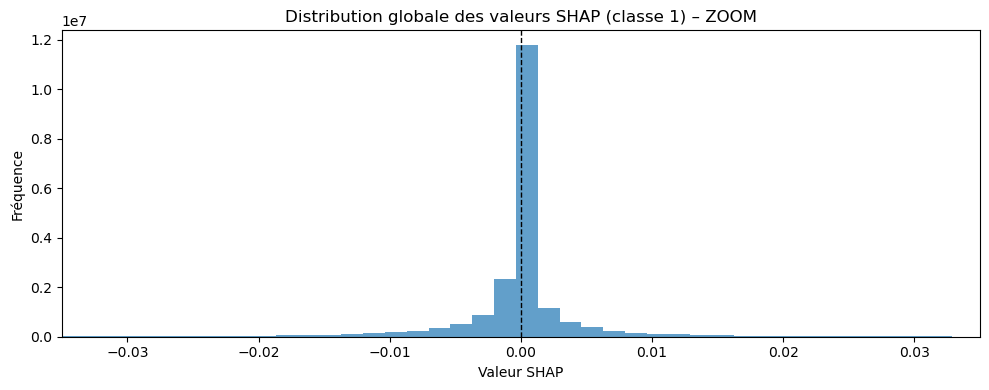

Features globalement inutiles : 1091
Feature  globalement utilisées :  1825


In [92]:
# Analyse de la distribution des valeurs SHAP pour la classe 1 (COVID)
# ---------------------------------------------------------------
# - Extraction de toutes les valeurs SHAP pour la classe 1
# - Histogramme zoomé sur la zone [-0.035, 0.035] pour visualiser les faibles contributions
# - Calcul de la contribution moyenne absolue par feature
# - Comptage des features utiles / inutiles
# ---------------------------------------------------------------

shap_mean = np.abs(shap_value_train[:,:,1].values).mean(axis=0)

import numpy as np
import matplotlib.pyplot as plt

# SHAP en numpy pour la classe 1
sh = shap_value_train[:, :, 1].values  
sh_flat = sh.flatten()

plt.figure(figsize=(10,4))

# Histogramme centré autour de zéro
plt.hist(sh_flat, bins=500, alpha=0.7)

# Ligne verticale à 0
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlim(-0.035, 0.035)  # ZOOM automatique sur les petites valeurs SHAP
plt.title("Distribution globale des valeurs SHAP (classe 1) – ZOOM")
plt.xlabel("Valeur SHAP")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()


# Moyenne absolue des SHAP par feature
shap_mean = np.abs(sh).mean(axis=0)    # shape (n_features,)


# Comptage des features contributives
Contribution_NULLE=len(shap_mean[(shap_mean == 0)])
Contribution_NON_NULLE=len(shap_mean[(shap_mean != 0)])
# Nombre
print("Features globalement inutiles :", Contribution_NULLE)
print("Feature  globalement utilisées : ", Contribution_NON_NULLE)


## Interprétation de l’histogramme des valeurs SHAP

Les 1 091 features inutiles correspondent aux dimensions du vecteur HOG qui :
 - soit n'ont capté aucune information pertinente pour distinguer la classe covid,
 - soit n’ont jamais été utilisées dans les splits des arbres du modèle.

Concernant la répartition, on observe des valeurs SHAP négatives et positives.
Cela indique que, pour un échantillon donné :

 - certaines features contribuent positivement à la prédiction de la classe,
 - d’autres la repoussent en contribuant négativement.

Pour chaque échantillon, la somme de toutes les contributions SHAP (positives + négatives), plus la valeur de base (expected value), donne le score final du modèle pour cette classe.

## Vision globale SHAP – Importance des features pour les 3 classes (X_train)

#### Dans cette cellule, nous analysons les valeurs SHAP globales calculées sur X_train.
#### Cela permet d’observer ce que le modèle a réellement "vu" pendant l’entraînement.


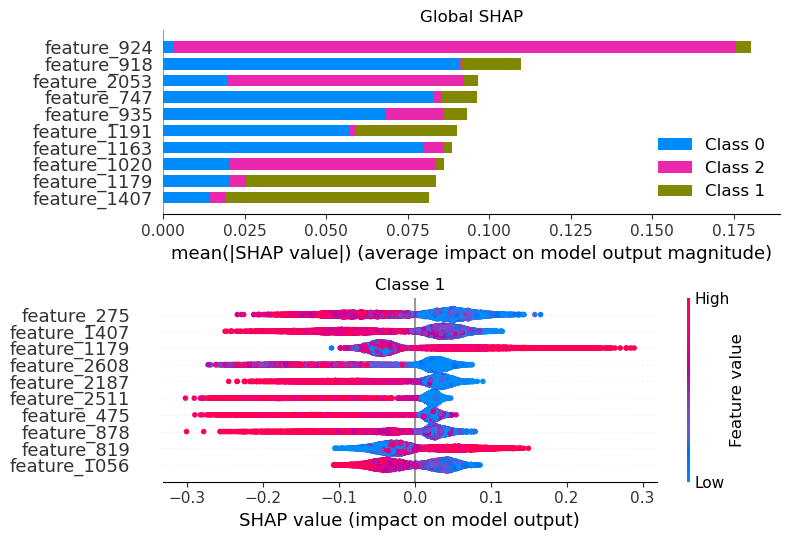

In [74]:
fig, axes = plt.subplots(2, 1, figsize=(20, 7))

#plot_type="bar"

# --- Global SHAP ---
plt.sca(axes[0])
shap.summary_plot(shap_value_train[:,:,], X_train_shape,plot_type="bar", show=False,max_display=10)
axes[0].set_title("Global SHAP")

# --- Classe 1 SHAP ---
plt.sca(axes[1])
shap.summary_plot(shap_value_train[:,:,1], X_train_shape, show=False,max_display=10)
axes[1].set_title("Classe 1")

# --- Espacements améliorés ---

plt.subplots_adjust(
   wspace=1,   # espace horizontal (augmente beaucoup)
  hspace=0.4,   # espace vertical
 left=0.05,
 right=0.95,
 top=0.92,
bottom=0.08
)

plt.tight_layout()
plt.show()  

### 🔍 Sélection des features affichées  
Comme vu précédemment, nous affichons seulement les **10 features les plus importantes** (`max_display=10`) afin d’éviter de surcharger l’écran.

Cependant, il est important de rappeler que **chaque échantillon utilise bien l’ensemble des 1825 features** pour calculer le logit final :

\[
\text{logit}_{\text{classe}} = \text{Base value} + \sum (\text{SHAP négatif} + \text{SHAP positif})
\]

Autrement dit :  
➡️ **toutes les features contribuent**, mais seules les plus influentes sont affichées.

---

### 🔵 Graphique de gauche — Importance globale des features  
Ce graphique montre les principales features classées du **plus fort impact** au **moins fort**.

- La **longueur des barres** indique la contribution moyenne de chaque feature.  
- Plus une barre est longue, plus la feature influence les prédictions du modèle.

---

### 🔴 Graphique de droite — Répartition des valeurs SHAP  
Ce graphique illustre la **densité des valeurs SHAP** pour chaque feature :

- Plus la **répartition est étalée**, plus la feature a un impact important et variable.  
- La **couleur représente la valeur du feature** :  
  - **rouge** → valeurs élevées  
  - **bleu** → valeurs faibles  
- Une **valeur SHAP positive** pousse la prédiction **vers la classe**.  
- Une **valeur SHAP négative** pousse la prédiction **contre la classe**.

Cela permet de comprendre **comment** et **dans quel sens** chaque feature influence la prédiction.


# Visualisation local via force plot pour un echantillon sur X_test lors de la prediction


ici nous prenons les top 10 features pour afficher les force plot.
Remarque: il s'agit simplement du rendu visuel afin de voiture le nom des features inscrit mais le logi final est calcul à partir de l'ensemble des valeurs de shape pour chaque features NON NULL.


### 🔎 Visualisation locale avec force plot pour un échantillon de **X_test**

Dans cette cellule, nous analysons la prédiction locale pour un échantillon de **X_test** à l’aide des **force plots SHAP**.

Nous affichons ici les **top 10 features** les plus influentes (sélectionnées uniquement pour des raisons de lisibilité).  
⚠️ **Important** : le **logit final** utilisé par le modèle est réellement calculé à partir de **toutes les valeurs SHAP non nulles**, même si seules les plus importantes sont visualisées ici.

---

### 🎯 Objectif  
- Visualiser comment chaque feature pousse la prédiction **vers** ou **contre** chacune des 3 classes.  
- Comprendre pourquoi, pour cet échantillon, la classe 1 est prédite comme gagnante.

---

### 🧩 Interprétation  
- Chaque force plot montre la **Base value**, puis l’effet cumulatif des features les plus influentes.  
- Les valeurs SHAP **positives** tirent la prédiction vers la classe.  
- Les valeurs SHAP **négatives** tirent la prédiction contre cette classe.  
- En comparant les logits des 3 classes, on voit laquelle l’emporte.  

Enfin, les probabilités retournées par `y_prob_test` confirment la classe prédite pour cet échantillon.



Exemple sur l'echantillons 0 voici les trois force plot
Classe 0: Normal


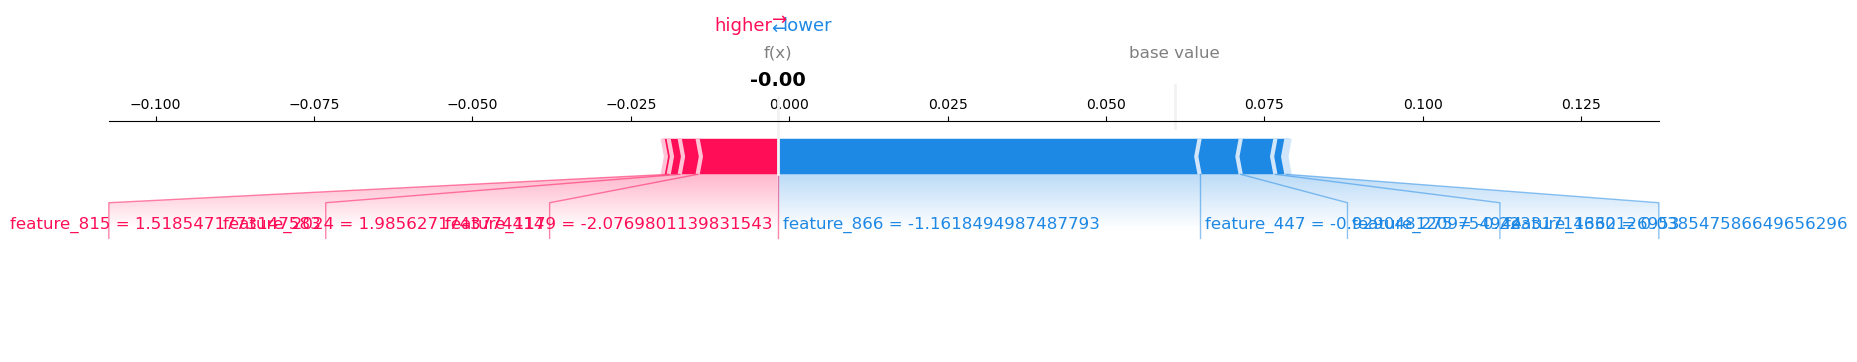

Classe 1: Covid


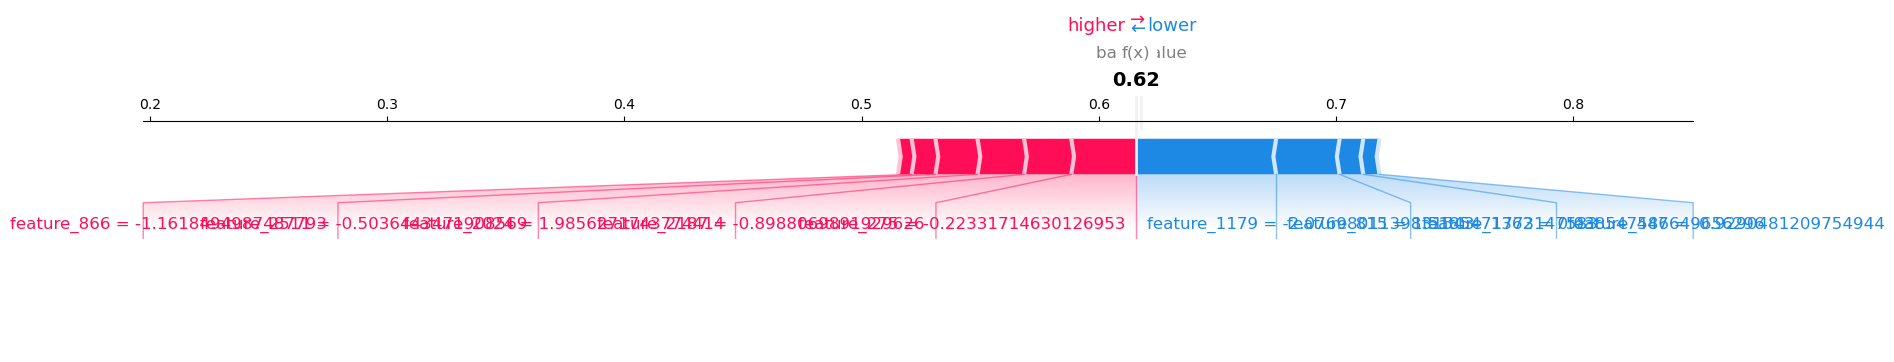

Classe 2: Autre


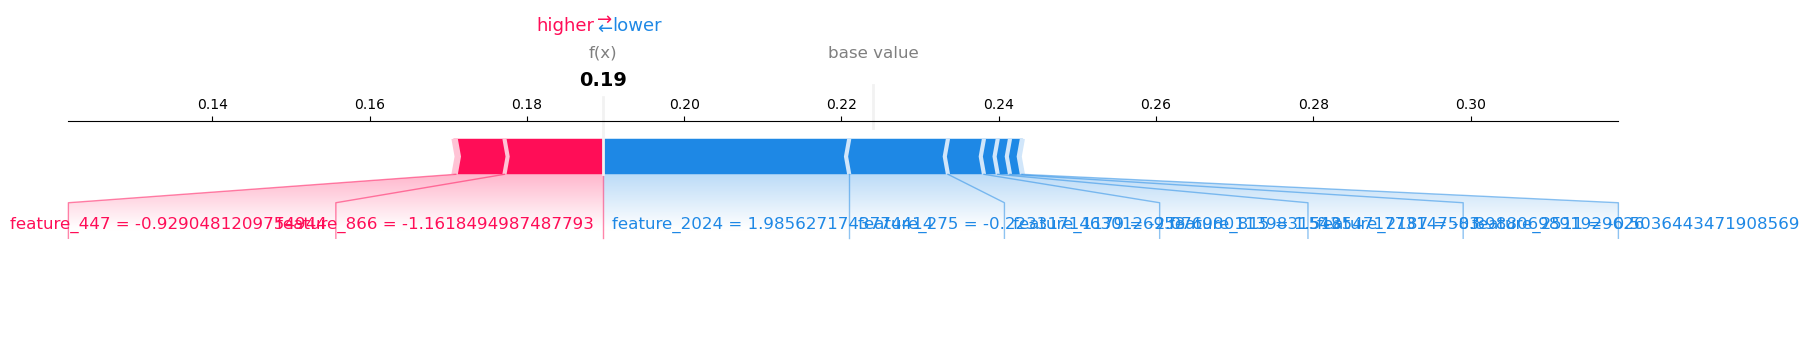

Pour l'échantillon 0 :
- Les probabilités d'appartenance aux classes retournées par `y_prob_test` sont :
[0.22278395 0.31621125 0.46100473]
- La classe prédite par le modèle est donc la **classe 2**.

- Attention : le force plot n'affiche que les top 10 features les plus importantes, donc il ne montre pas l'effet cumulatif complet de toutes les features sur le logit final.


In [96]:
import shap

shap.initjs()
# Choisir l'échantillon et la classe
i = 0              # échantillon 0
class_idx0 = 0      # classe 0
class_idx1 = 1      # classe 1
class_id2 = 2     # classe 2
top_n = 10         # nombre de features à afficher

# SHAP values pour cet échantillon et cette classe
shap_vals0 = shap_value.values[i, :, class_idx0]
shap_vals1 = shap_value.values[i, :, class_idx1]
shap_vals2 = shap_value.values[i, :, class_id2]

# Récupérer les indices des top N features par valeur absolue
top_idx = np.argsort(np.abs(shap_vals))[::-1][:top_n]

# Créer un objet Explanation pour ces top features
ex0 = shap.Explanation(
    values = shap_vals0[top_idx],                  # SHAP values des top features
    base_values = explainer.expected_value[class_idx0],  # valeur de base pour la classe
    data = X_test_shape.iloc[i, top_idx],        # valeurs réelles des top features
    feature_names = X_test_shape.columns[top_idx] # noms des top features
)
print(f"Exemple sur l'echantillons {i} voici les trois force plot")
print("Classe 0: Normal")
shap.plots.force(ex0,matplotlib=True)


ex1 = shap.Explanation(
    values = shap_vals1[top_idx],                  # SHAP values des top features
    base_values = explainer.expected_value[class_idx1],  # valeur de base pour la classe
    data = X_test_shape.iloc[i, top_idx],        # valeurs réelles des top features
    feature_names = X_test_shape.columns[top_idx] # noms des top features
)
print("Classe 1: Covid")
shap.plots.force(ex1,matplotlib=True)


ex2 = shap.Explanation(
    values = shap_vals2[top_idx],                  # SHAP values des top features
    base_values = explainer.expected_value[class_id2],  # valeur de base pour la classe
    data = X_test_shape.iloc[i, top_idx],        # valeurs réelles des top features
    feature_names = X_test_shape.columns[top_idx] # noms des top features
)
print("Classe 2: Autre")
shap.plots.force(ex2,matplotlib=True)


#print(f"pour l'echantillons {i} - on voit que le logit final qui l'emporte est celui de la classe 1 donc le modele va predire classe 1  \n")

#print(f" Les probabilité d'appartenance a une classe retourné par y_prob_test pour l'echantillon {i} sont : \n"
#f" {y_prob_test[0]} ")


# Identifier la classe prédite à partir des probabilités
predicted_class = np.argmax(y_prob_test[i])

print(f"Pour l'échantillon {i} :")
print(f"- Les probabilités d'appartenance aux classes retournées par `y_prob_test` sont :\n{y_prob_test[i]}")
print(f"- La classe prédite par le modèle est donc la **classe {predicted_class}**.\n")
print("- Attention : le force plot n'affiche que les top 10 features les plus importantes, "
      "donc il ne montre pas l'effet cumulatif complet de toutes les features sur le logit final.")



Dans le force plot, On affiches seulement les top 10 features pour visualiser leur contribution.

Le logit final du modèle (et donc la classe prédite) est calculé en additionnant les SHAP de **toutes les features non nulles**, pas seulement celles des top 10.

C’est pourquoi, même si sur le graphique certaines features semblent pousser vers la classe 1, la classe 2 a en réalité la probabilité la plus élevée (0.461) quand on considère toutes les features.